<a href="https://colab.research.google.com/github/dvellanki/GAN-VAE-AutoEncoder/blob/main/Autoencoder_confusionmatrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image

num_epochs = 50
batch_size = 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
trainset = tv.datasets.MNIST(root='./data',  train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = nn.Sequential(
            # 28 x 28
            nn.Conv2d(1, 4, kernel_size=5),
            # 4 x 24 x 24
            nn.ReLU(True),
            nn.Conv2d(4, 8, kernel_size=5),
            nn.ReLU(True),
            # 8 x 20 x 20 = 3200
            nn.Flatten(),
            nn.Linear(3200, 10),
            # 10
            nn.Softmax(),
            )
        self.decoder = nn.Sequential(
            # 10
            nn.Linear(10, 400),
            # 400
            nn.ReLU(True),
            nn.Linear(400, 4000),
            # 4000
            nn.ReLU(True),
            nn.Unflatten(1, (10, 20, 20)),
            # 10 x 20 x 20
            nn.ConvTranspose2d(10, 10, kernel_size=5),
            # 24 x 24
            nn.ConvTranspose2d(10, 1, kernel_size=5),
            # 28 x 28
            nn.Sigmoid(),
            )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder().cpu()
distance = nn.MSELoss()
#distance = nn.BCELoss()
#distance = nn.BCEWithLogitsLoss()
#optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-5)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = Variable(img).cpu()
        output = model(img)
        loss = distance(output, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch [{}/{}], loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))


epoch [1/50], loss: 0.9162
epoch [2/50], loss: 0.7587
epoch [3/50], loss: 0.7438
epoch [4/50], loss: 0.7353
epoch [5/50], loss: 0.7265
epoch [6/50], loss: 0.6565
epoch [7/50], loss: 0.6519
epoch [8/50], loss: 0.7458
epoch [9/50], loss: 0.6799
epoch [10/50], loss: 0.6719
epoch [11/50], loss: 0.6387
epoch [12/50], loss: 0.6453
epoch [13/50], loss: 0.6585
epoch [14/50], loss: 0.7193
epoch [15/50], loss: 0.6207
epoch [16/50], loss: 0.6726
epoch [17/50], loss: 0.6470
epoch [18/50], loss: 0.6605
epoch [19/50], loss: 0.6069
epoch [20/50], loss: 0.6530
epoch [21/50], loss: 0.6633
epoch [22/50], loss: 0.6689
epoch [23/50], loss: 0.6568
epoch [24/50], loss: 0.6872
epoch [25/50], loss: 0.6723
epoch [26/50], loss: 0.6291
epoch [27/50], loss: 0.6846
epoch [28/50], loss: 0.6415
epoch [29/50], loss: 0.6629
epoch [30/50], loss: 0.6381
epoch [31/50], loss: 0.6221
epoch [32/50], loss: 0.6367
epoch [33/50], loss: 0.6484
epoch [34/50], loss: 0.6658
epoch [35/50], loss: 0.6381
epoch [36/50], loss: 0.6105
e

In [3]:
import numpy as np
np.set_printoptions(suppress=True)

confusion_matrix = np.zeros((10, 10))

batch_size = 20*1000

testset = tv.datasets.MNIST(root='./data',  train=False, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=4)

for data in dataloader:
    imgs, labels = data
    imgs = Variable(imgs).cpu()
    encs = model.encoder(imgs).detach().numpy()
    for i in range(len(encs)):
        predicted = np.argmax(encs[i])
        actual = labels[i]
        confusion_matrix[actual][predicted] += 1
print(confusion_matrix)
print(int(confusion_matrix.sum()))

[[  7.  60.   0. 675.   0.   2. 165.  51.  20.   0.]
 [  3.   0.   0.   0.   0. 597.   0. 530.   5.   0.]
 [  1.  28.   0. 157.   0. 451. 291.  66.  38.   0.]
 [  2. 145.   0.  89.   0. 686.   3.  38.  47.   0.]
 [  2. 252.   0.  10.   0.   0.  47.  42. 629.   0.]
 [ 47. 374.   0. 125.   0. 119.   0. 161.  66.   0.]
 [196.   3.   0. 370.   0.  57. 148.  82. 102.   0.]
 [  0. 667.   0.   2.   0.  40.  27.  19. 273.   0.]
 [  1. 566.   0.  91.   0. 209.   5.  74.  28.   0.]
 [  1. 373.   0.   4.   0.   6.   8.   3. 614.   0.]]
10000


In [4]:
active_neurons = set()
for actual in range(10):
    predicted = np.argmax(confusion_matrix[actual])
    pct = 100 * confusion_matrix[actual][predicted] / np.sum(confusion_matrix[actual])
    print('Actual label %d most likely activates on neuron %d (%d%%)' % (actual, predicted, pct))
    active_neurons.add(predicted)
active_neurons, len(active_neurons)

Actual label 0 most likely activates on neuron 3 (68%)
Actual label 1 most likely activates on neuron 5 (52%)
Actual label 2 most likely activates on neuron 5 (43%)
Actual label 3 most likely activates on neuron 5 (67%)
Actual label 4 most likely activates on neuron 8 (64%)
Actual label 5 most likely activates on neuron 1 (41%)
Actual label 6 most likely activates on neuron 3 (38%)
Actual label 7 most likely activates on neuron 1 (64%)
Actual label 8 most likely activates on neuron 1 (58%)
Actual label 9 most likely activates on neuron 8 (60%)


({1, 3, 5, 8}, 4)

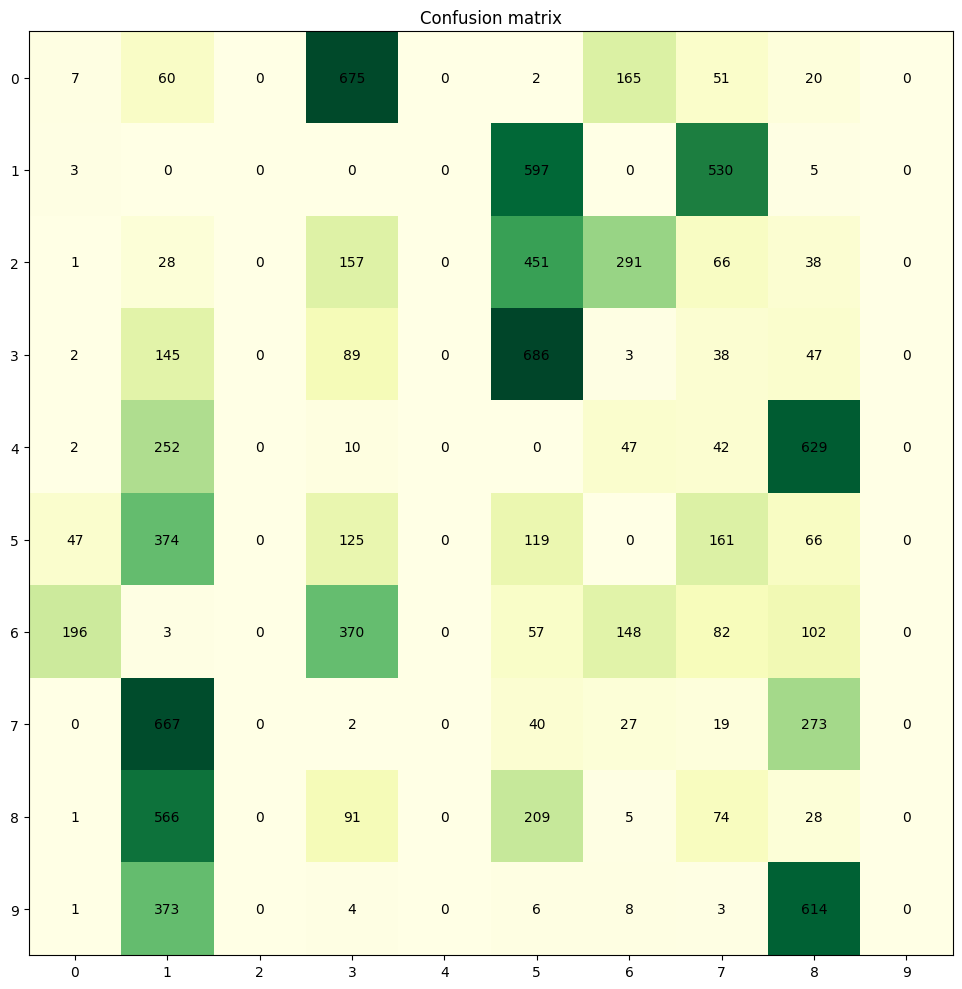

In [5]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(confusion_matrix, cmap="YlGn")
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_title("Confusion matrix")
for i in range(10):
    for j in range(10):
        text = ax.text(j, i, int(confusion_matrix[i, j]),
                       ha="center", va="center")
fig.tight_layout()
plt.show()